# 32x32 expGP image reconstruction

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions

In [3]:
def get_ps(x, nbins = 50):
    """Extracts the unnormalized power-spectrum based on quadratic input images."""
    N = x.shape[-1]
    freq = torch.fft.fftfreq(N)
    kx, ky = torch.meshgrid(freq, freq)
    k = (kx**2+ky**2)**0.5
    k = k.flatten()
    kedges = torch.linspace(k.min(), k.max()/2**0.5, nbins+1)
    
    fx = torch.fft.ifft2(x).flatten(start_dim=-2)
    PS = []
    for i in range(nbins):
        y = fx[..., (k>=kedges[i])*(k<kedges[i+1])]
        y = torch.abs(y)**2
        PS.append(y.mean(dim=-1).view(-1))
    PS = torch.stack(PS, dim=-1).T
    return PS

In [4]:
def cg_batch(A_bmm, B, M_bmm=None, X0=None, rtol=1e-3, atol=0., maxiter=None, verbose=False):
    # Adopted from https://github.com/sbarratt/torch_cg/blob/master/LICENSE.md
    """Solves a batch of PD matrix linear systems using the preconditioned CG algorithm.

    This function solves a batch of matrix linear systems of the form

        A_i X_i = B_i,  i=1,...,K,

    where A_i is a n x n positive definite matrix and B_i is a n x m matrix,
    and X_i is the n x m matrix representing the solution for the ith system.

    Args:
        A_bmm: A callable that performs a batch matrix multiply of A and a K x n x m matrix.
        B: A K x n x m matrix representing the right hand sides.
        M_bmm: (optional) A callable that performs a batch matrix multiply of the preconditioning
            matrices M and a K x n x m matrix. (default=identity matrix)
        X0: (optional) Initial guess for X, defaults to M_bmm(B). (default=None)
        rtol: (optional) Relative tolerance for norm of residual. (default=1e-3)
        atol: (optional) Absolute tolerance for norm of residual. (default=0)
        maxiter: (optional) Maximum number of iterations to perform. (default=5*n)
        verbose: (optional) Whether or not to print status messages. (default=False)
    """
    K, n, m = B.shape

    if M_bmm is None:
        M_bmm = lambda x: x
    if X0 is None:
        X0 = M_bmm(B)
    if maxiter is None:
        maxiter = 5 * n

    assert B.shape == (K, n, m)
    assert X0.shape == (K, n, m)
    assert rtol > 0 or atol > 0
    assert isinstance(maxiter, int)

    X_k = X0
    R_k = B - A_bmm(X_k)
    Z_k = M_bmm(R_k)

    P_k = torch.zeros_like(Z_k)

    P_k1 = P_k
    R_k1 = R_k
    R_k2 = R_k
    X_k1 = X0
    Z_k1 = Z_k
    Z_k2 = Z_k

    B_norm = torch.norm(B, dim=1)
    stopping_matrix = torch.max(rtol*B_norm, atol*torch.ones_like(B_norm))

    if verbose:
        print("%03s | %010s %06s" % ("it", "dist", "it/s"))

    optimal = False
    start = time.perf_counter()
    for k in range(1, maxiter + 1):
        start_iter = time.perf_counter()
        Z_k = M_bmm(R_k)

        if k == 1:
            P_k = Z_k
            R_k1 = R_k
            X_k1 = X_k
            Z_k1 = Z_k
        else:
            R_k2 = R_k1
            Z_k2 = Z_k1
            P_k1 = P_k
            R_k1 = R_k
            Z_k1 = Z_k
            X_k1 = X_k
            denominator = (R_k2 * Z_k2).sum(1)
            denominator[denominator == 0] = 1e-8
            beta = (R_k1 * Z_k1).sum(1) / denominator
            P_k = Z_k1 + beta.unsqueeze(1) * P_k1

        denominator = (P_k * A_bmm(P_k)).sum(1)
        denominator[denominator == 0] = 1e-8
        alpha = (R_k1 * Z_k1).sum(1) / denominator
        X_k = X_k1 + alpha.unsqueeze(1) * P_k
        R_k = R_k1 - alpha.unsqueeze(1) * A_bmm(P_k)
        end_iter = time.perf_counter()

        residual_norm = torch.norm(A_bmm(X_k) - B, dim=1)

        if verbose:
            print("%03d | %8.4e %4.2f" %
                  (k, torch.max(residual_norm-stopping_matrix),
                    1. / (end_iter - start_iter)))

        if (residual_norm <= stopping_matrix).all():
            optimal = True
            break

    end = time.perf_counter()

    if verbose:
        if optimal:
            print("Terminated in %d steps (reached maxiter). Took %.3f ms." %
                  (k, (end - start) * 1000))
        else:
            print("Terminated in %d steps (optimal). Took %.3f ms." %
                  (k, (end - start) * 1000))


    info = {
        "niter": k,
        "optimal": optimal
    }

    return X_k, info


class CG:

    def __init__(self, A_bmm, M_bmm=None, rtol=1e-3, atol=0., maxiter=None, verbose=False):
        self.A_bmm = A_bmm
        self.M_bmm = M_bmm
        self.rtol = rtol
        self.atol = atol
        self.maxiter = maxiter
        self.verbose = verbose

    def forward(self, B, X0=None):
        X, _ = cg_batch(self.A_bmm, B, M_bmm=self.M_bmm, X0=X0, rtol=self.rtol,
                     atol=self.atol, maxiter=self.maxiter, verbose=self.verbose)
        return X

#    def backward(self, dX):
#        dB, _ = cg_batch(self.A_bmm, dX, M_bmm=self.M_bmm, rtol=self.rtol,
#                      atol=self.atol, maxiter=self.maxiter, verbose=self.verbose)
#        return dB

### Generative model

In [235]:
class PowerSampler:
    def __init__(self, N, boxlength = 1.0):
        self.N = N
        d = boxlength/N
        freq = torch.fft.fftfreq(N, d=d)
        kx, ky = torch.meshgrid(freq, freq)
        k = (kx**2+ky**2)**0.5
        self.k = k + k[0,1]  # Offset to avoid singularities

    def sample(self, pk):
        N = self.N
        A = (torch.randn(N,N)+1j*torch.randn(N,N))/np.sqrt(2)  # Random complex amplitudes
        phi_k = A*pk(self.k)**0.5
        phi_x = torch.fft.ifft2(phi_k, norm = 'ortho')
        return phi_x.real

In [236]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = PowerSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.01
        self.sigma[:, :Npix//2] *= 0.01
            
    def build(self, graph):
        theta = graph.node("alpha", self.theta_sampler)
        delta = graph.node("delta", lambda theta: self.powersampler.sample(lambda k: 3*(k/0.5)**-theta[0]), theta)
      #  rho = graph.node("rho", lambda delta: torch.exp(1e2*delta), delta)
     #   x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*0.01, rho)
        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)

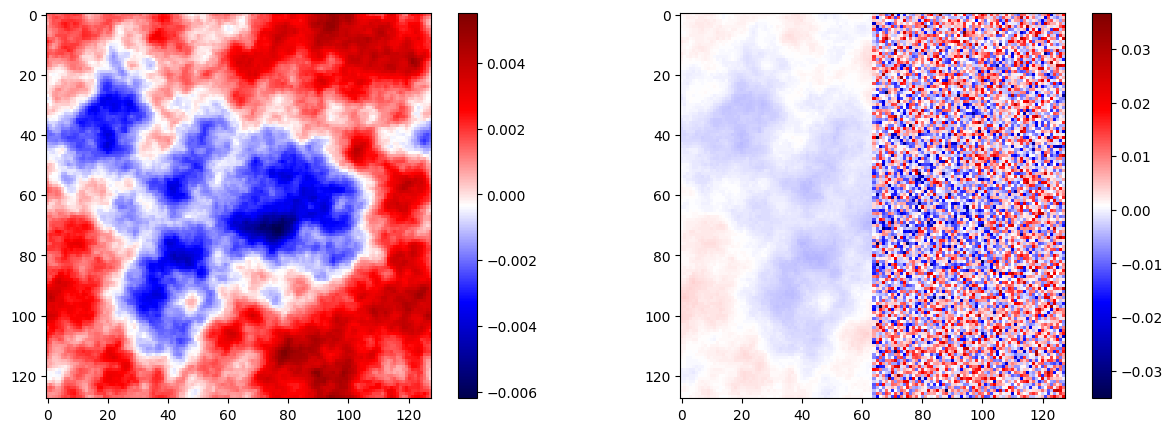

In [237]:
NPIX = 128
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(sample0['delta'], cmap = 'seismic')
plt.colorbar()
plt.subplot(122)
plt.imshow(sample0['x'], cmap = 'seismic')
plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 883.51it/s]


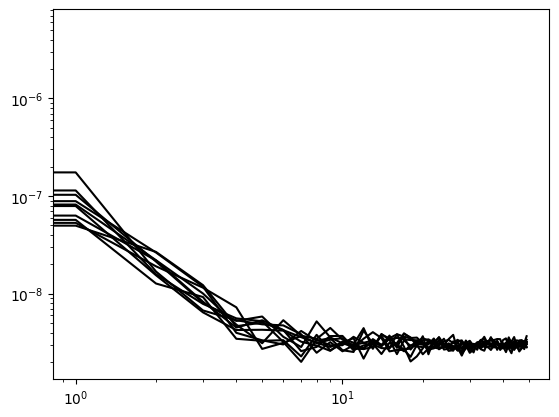

In [238]:
samples = sim.sample(10)
PS = get_ps(torch.tensor(samples['x']).cuda()).cpu()

#PS = torch.log(PS).cpu()
    
plt.loglog(PS, 'k');
#plt.semilogy(PS[:,0]+PS[:,1], 'k--')
#plt.semilogy(PS[:,0]-PS[:,1], 'k--')
#plt.axvline(400/2**0.5)
#plt.semilogy(K, 3*(K/0.5)**-4)

### Inference network

In [239]:
class StrideConv(torch.nn.Module):
    def __init__(self, l_max = 1):
        super().__init__()
        self.convs = torch.nn.ModuleList(
            [torch.nn.Conv2d(1, 1, 3, padding = i, dilation = i, bias = False) 
             for i in [2**l for l in range(l_max)]]
        )
        self.convs_trans = torch.nn.ModuleList(
            [torch.nn.ConvTranspose2d(1, 1, 3, padding = i, dilation = i, bias = False) 
             for i in [2**l for l in range(l_max)]]
        )
    
    def forward(self, x):
        x1 = x.unsqueeze(1)  # B, 1, N, N
        x1 = [conv(x1) for conv in self.convs]
        x1 = sum(x1).squeeze(1)
        return x1#*0 + x
    
    def T(self, x):
        x1 = x.unsqueeze(1)  # B, 1, N, N
        for i, conv in enumerate(self.convs):
            self.convs_trans[i].weight = conv.weight
        x1 = [conv(x1) for conv in self.convs_trans]
        x1 = sum(x1).squeeze(1)
        return x1#*0 + x

In [240]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x
        self.conv = StrideConv(l_max = 1)
        self.Phi = lambda x: self.conv(x.view(-1, N, N)).view(-1, N*N)
        self.PhiT = lambda x: self.conv.T(x.view(-1, N, N)).view(-1, N*N)
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-4)
        self.l = torch.nn.LazyLinear(1)

    def forward(self, A, B):
        N = self.N
        rhoA = A['x'].view(-1, N**2)
        rhoB = B['x'].view(-1, N**2)
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [241]:
sim = SimulatorBlob(Npix = NPIX)
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1046.40it/s]


In [242]:
net = Network(N = NPIX)

In [243]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 20)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | conv | StrideConv                                               | 18    
1 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
2 | l    | LazyLinear                                               | 0     
----------------------------------------------------------------------------------
18        Trainable params
0         Non-trainable params
18        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  88%|██████████████████████████████████████████████████████████████████████████████████▉           | 15/17 [00:00<00:00, 19.95it/s, loss=-3.01e+04, v_num=50]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████▏        | 15/17 [00:00<00:00, 21.10it/s, loss=-3.02e+04, v_num=50, val_loss=-3.02e+4]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|██████████████████████████████████████████████████████████████████▏        | 15/17 [00:00<00:00, 19.82it/s, loss=-3.02e+04, v_num=50, val_loss=-3.02e+4]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████▏        | 15/17 [00:00<00:00, 21.58it/s, loss=-3.02e+04, v_num=50, val_loss=-3.02e+4]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████▏        | 15/17 [00:00<00:00, 20.14it/s, loss=-3.02e+04, v_num=50, val_loss=-3.02e+4]
Validation: 0it [00:00, ?it/s]
Epoch 5:  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.31it/s, loss=-3.02e+04, v_num=50, val_loss=-3.02e+4]


### Evaluation

In [245]:
net.cuda()
net.double()
x = sample0['x']
x = torch.tensor(x).flatten().double().cuda()
G1Tt, D1, G1t, b = net.lre.get_likelihood_components(x)
G1T = lambda x: G1Tt(x.unsqueeze(0))[0]
G1 = lambda x: G1t(x.unsqueeze(0))[0]
D1 += 0.00000001

k = PowerSampler(NPIX).k
D2 = 3*(k/0.5)**-4.042
D2 = D2.view(-1).double().cuda()

N = NPIX
U2 = lambda x: torch.fft.fft2(x.view(N, N), norm = 'ortho').view(N*N)
U2T = lambda x: torch.fft.ifft2(x.view(N, N), norm = 'ortho').view(N*N)

In [267]:
geda = swyft.utils.GEDASampler(2e-7, G1, D1, G1T, U2, 1/D2, U2T)
x = geda.sample(8, steps = 2000, reset = True)

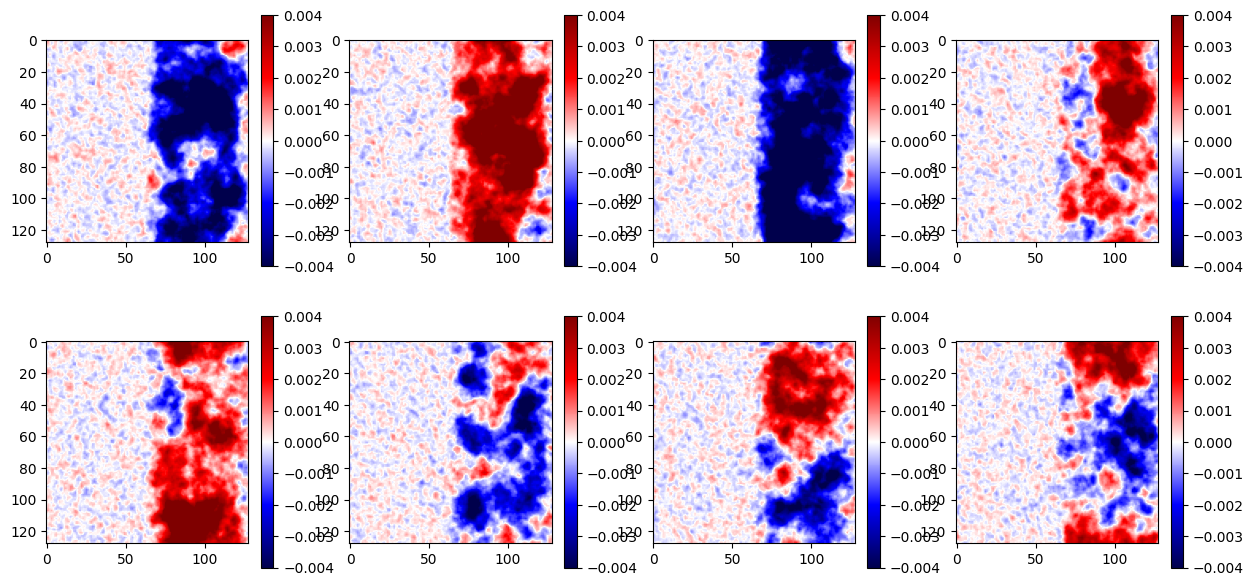

In [268]:
v = 0.004
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(x[i].view(N, N).cpu(), vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

In [269]:
def A(x):
    x = x[0,:,0]
    x1 = U2(x).detach()
    x1 *= 1/D2
    x1 = U2T(x1).real.detach()
    x2 = G1(x).detach()
    x2 *= D1
    x2 = G1T(x2).detach()
    x = x1 + x2
    return x.view(1, -1, 1).detach()/1e4

In [270]:
cg = CG(A, rtol = 0.001, verbose = False, maxiter = 1000000)
x0 = cg.forward(b.cuda().view(1, -1, 1).detach()/1e4)

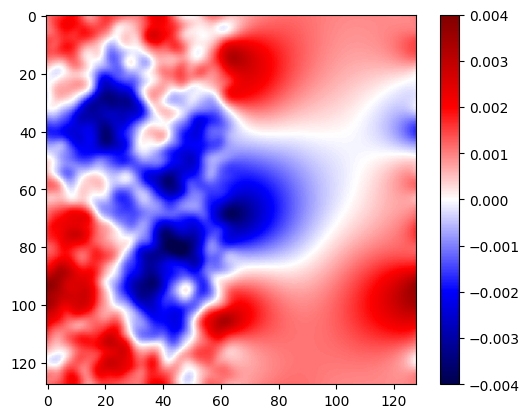

In [271]:
plt.imshow(x0.view(NPIX, NPIX).cpu().detach(), vmin = -v, vmax = v, cmap = 'seismic')
plt.colorbar()

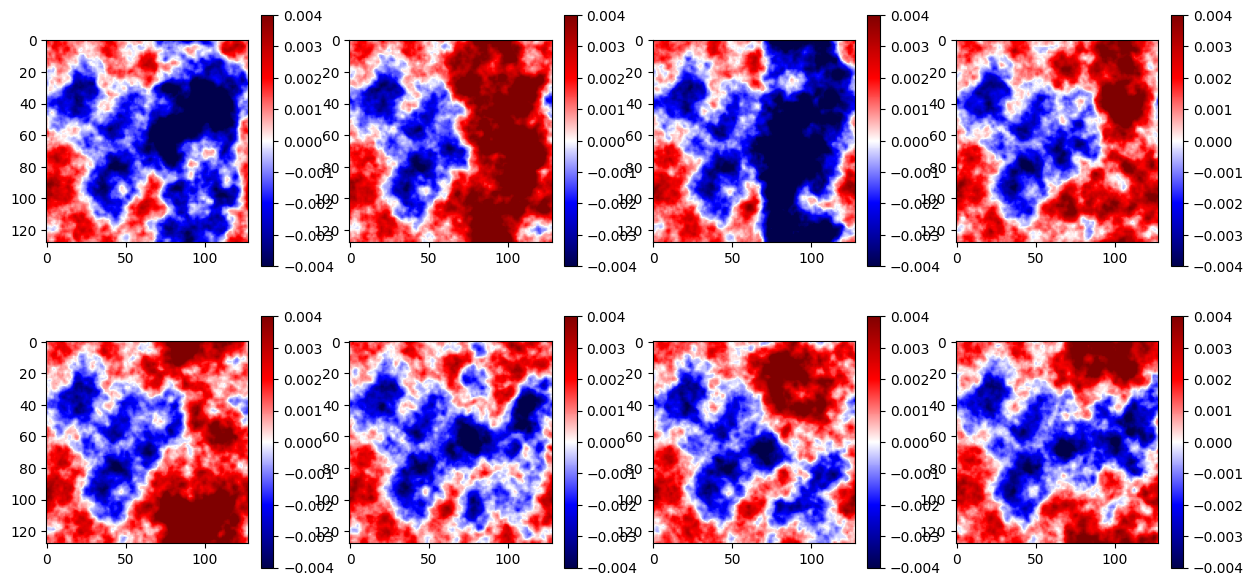

In [272]:
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(x0.view(NPIX, NPIX).cpu().detach() + x[i].view(N, N).cpu(), cmap = 'seismic', vmin = -v, vmax = v)
    plt.colorbar()

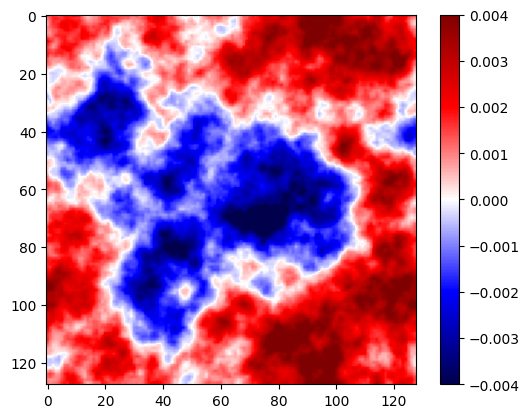

In [273]:
plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
plt.colorbar()

[4.016929]


(0.0, 2.0)

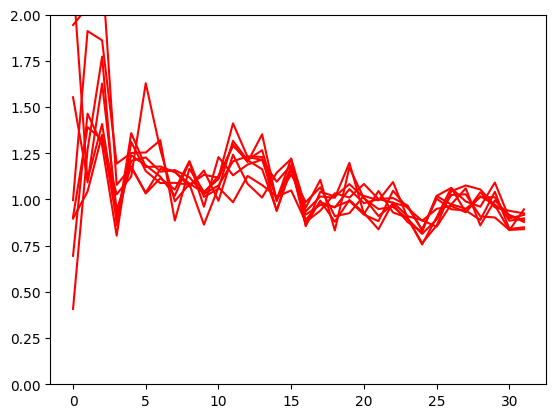

In [276]:
ps0 = get_ps(torch.tensor(sample0['delta']), nbins = 32)
print(sample0['alpha'])
#plt.loglog(ps0[:,0], 'k', lw = 2)
for i in range(8):
    ps = get_ps(x0.view(NPIX, NPIX).cpu().detach() + x[i].view(N, N).cpu(), nbins = 32)
    plt.plot(ps[:,0]/ps0[:,0], 'r')
#for _ in range(30):
#    sample1 = sim.sample()
#    ps1 = get_ps(torch.tensor(sample1['delta']))
#    plt.plot(ps1[:,0]/ps0[:,0], 'g')
#plt.xlim([5, 50])
plt.ylim([0, 2])